1-j_integral(kj/m^2)_ml: 5.732250275011814
1-j_integral(kj/m^2)_dic: 4.879710379759625


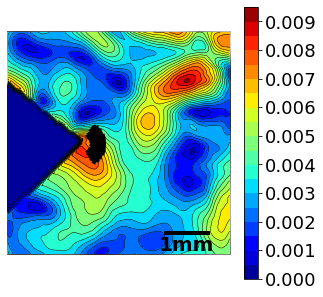

0.2


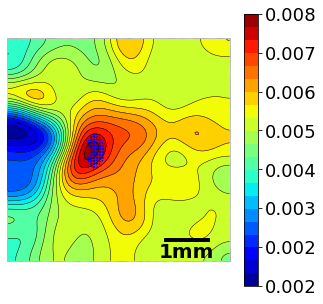

In [2]:
import mecha.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mecha.fracture as fracture
from scipy import io
import matplotlib.patches as patches

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# Material property
n_hardening=17
yield_strength=535.435
alpha=0.585
In=2.78
youngs_modulus=71.7*1000
ml_slope=170

# Img parameter
contour_level = 20
ratio = 2/60
left, right, up_down = 50,100,75

#DIC parameter
scale_factor=2
deg=60
radius_gap = 1
gap_count = 10


start_gap = 0.2
num=1

crack_tip = [[401,208],[395,211],[391,206],[388,207],[385,203]] # y, x
"""

start_gap = 0.2
num=1

start_gap = 0.55
num=2

start_gap = 0.85
num=3


start_gap = 1.0
num= 4

"""
j = num
path =r'E:\experiment data\aluminum\2021-03-30_cts\3_normal_check'



##data load part##
image = dic.load_file('../data_new/CTS')
strain_hardening = np.array(pd.read_csv('./data/HRR.csv', delim_whitespace=True))
uu = io.loadmat('../data_new/CTS/data'+'/'+str(j)+'_uu.mat')['uu']
vv = io.loadmat('../data_new/CTS/data'+'/'+str(j)+'_vv.mat')['vv']
exx = io.loadmat('../data_new/CTS/data'+'/'+str(j)+'_exx.mat')['exx']
eyy = io.loadmat('../data_new/CTS/data'+'/'+str(j)+'_eyy.mat')['eyy']
exy = io.loadmat('../data_new/CTS/data'+'/'+str(j)+'_exy.mat')['exy']
ee = fracture.effective_strain_z(0.33, exx, eyy, exy)
uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )
exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
exy_resize = cv2.resize(exy,(0,0),fx=2, fy=2 )
ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

eps_rr, eps_tt, eps_rt = strain_hardening[:,1], strain_hardening[:,2] ,strain_hardening[:,3]
strain_bar = np.sqrt(4* (np.power(eps_rr,2) + np.power(eps_tt,2) - eps_rr*eps_tt + 3 * np.power(eps_rt,2)) /9)
strain_hardening = np.hstack((strain_hardening[:,0].reshape(-1,1),strain_bar.reshape(-1,1)))


##ML part##
ref = list(image.keys())[0]
cur = list(image.keys())[num]
src_reference = image[ref][:,:,1][crack_tip[0][0]-up_down:crack_tip[0][0]+up_down,crack_tip[0][1]-left:crack_tip[0][1]+right]
src_current = image[cur][:,:,1][crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]

max_crack_tip = [left,up_down]

dst = cv2.subtract(src_current.astype('float64'),src_reference.astype('float64'))
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
dst = np.where(dst<0, dst*0, dst)
gas = cv2.GaussianBlur(dst,(0,0),10)

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,deg,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,deg,0)))
        radius_g += radius_gap

df = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df.x = df.x + max_crack_tip[0]
df.y = df.y + max_crack_tip[1]
df.r = df.r

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_strain = np.append(effective_strain, current_ml/ml_slope)
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df['ml'] = ml
df['effective_strain'] = effective_strain
df['hardening_strain_bar'] = theta_list

plastic_k = np.power(df.effective_strain * youngs_modulus
                     / (df.hardening_strain_bar * alpha * yield_strength *
                        np.power(df.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus


print('{}-j_integral(kj/m^2)_ml:'.format(num), j_integral)

###DIC###
dst_dic = ee_resize[crack_tip[num][0]-up_down:crack_tip[num][0]+up_down,crack_tip[num][1]-left:crack_tip[num][1]+right]
dst_dic = dst_dic.astype(float)
dst_dic = np.where(dst_dic>10, dst_dic*0, dst_dic)
dic_gas = dst_dic

max_crack_tip = [left, up_down]

count = 0
radius_g = 0
location = []
for _ in range(1, gap_count):
    if count == 0:
        location = dic.circle_location(start_gap/ratio, ratio,deg,0)
        radius_g += radius_gap
        count += 1
    else:
        location = np.vstack((location, dic.circle_location(start_gap/ratio+radius_g, ratio,deg,0)))
        radius_g += radius_gap

df_dic = pd.DataFrame(location, columns=['x', 'y', 'angle', 'r'])
df_dic.x = df_dic.x + max_crack_tip[0]
df_dic.y = df_dic.y + max_crack_tip[1]
df_dic.r = df_dic.r


hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,1])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,1])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_strain=[]
theta_list = []

for y,x,theta in np.array(df_dic[['y','x','angle']]):
    effective_strain = np.append(effective_strain,dic_gas[np.round(y).astype(int),np.round(x).astype(int)])
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])

df_dic['effective_strain'] = effective_strain
df_dic['hardening_strain_bar'] = theta_list

plastic_k = np.power(df_dic.effective_strain * youngs_modulus
                     / (df_dic.hardening_strain_bar * alpha * yield_strength *
                        np.power(df_dic.r, (-1 * n_hardening/(n_hardening+1)))), 1/n_hardening)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus))

print('{}-j_integral(kj/m^2)_dic:'.format(num), j_integral)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
###DIC 그래프###
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 101,147, '1mm', fontsize=20, fontweight='bold')

ax.imshow(dic_gas, cmap='gray')
csf = ax.contourf(dic_gas, contour_level, cmap = 'jet')
CS = ax.contour(dic_gas, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf, format='%0.3f')
cbar.ax.tick_params(labelsize=18)

ax.axis('off')
plt.scatter(df.x, df.y, s = 10,  c='black', marker='<')
plt.savefig('../data_new/CTS/{}pick_dic.png'.format(str(j)),dpi=300,bbox_inches='tight')
plt.show()
plt.close()


###ML그래프###
fig, ax = plt.subplots(figsize=(5, 5))
ax.add_patch(
     patches.Rectangle(
        (105, 134),
        30,
        2,
        edgecolor = 'black',
        facecolor = 'black',
        fill=True
     ) )
plt.text( 101,147, '1mm', fontsize=20, fontweight='bold')
ax.imshow(src_current, cmap='gray')
plt.axis('off')
csf = ax.contourf(gas/ml_slope, contour_level, cmap = 'jet')
CS = ax.contour(gas/ml_slope, contour_level, colors='black', linewidths = 0.5)
cbar= plt.colorbar(csf, format='%0.3f')
cbar.ax.tick_params(labelsize=18)
plt.scatter(df.x, df.y, s = 0.2,  c='blue', marker='o')
# plt.scatter(df.x, df.y, s = 10,  c='black', marker='<')
# plt.scatter(gas.argmax()%150,gas.argmax()//150,color='white')
print(((gas.argmax()%150-50)**2 + (75-gas.argmax()//150)**2)**0.5/30)
plt.savefig('../data_new/CTS/{}pick_ml.png'.format(str(j)),dpi=300,bbox_inches='tight')
plt.show()
plt.close()

In [7]:
ml_angle_average_p = []
dic_angle_average_p = []
for i in df.angle.unique():
    ml_angle_average_p.append([i,df[df.angle == i].effective_strain.mean()])
    dic_angle_average_p.append([i,df_dic[df_dic.angle == i].effective_strain.mean()])

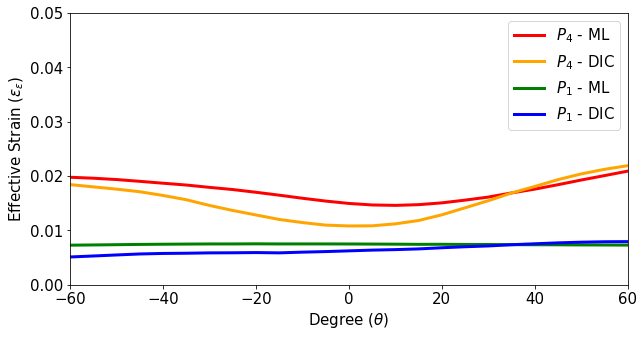

In [12]:
ml_angle_average = []
dic_angle_average = []
for i in df.angle.unique():
    ml_angle_average.append([i,df[df.angle == i].effective_strain.mean()])
    dic_angle_average.append([i,df_dic[df_dic.angle == i].effective_strain.mean()])

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.array(ml_angle_average)[:,0],np.array(ml_angle_average)[:,1], label='$P_4$ - ML', linestyle='dashed',color='red',linewidth = 3)
ax.plot(np.array(dic_angle_average)[:,0],np.array(dic_angle_average)[:,1], label='$P_4$ - DIC', linestyle='dashdot',color='orange',linewidth = 3)
ax.plot(np.array(ml_angle_average_p)[:,0],np.array(ml_angle_average_p)[:,1], label='$P_1$ - ML', linestyle= (0, (3, 1, 1, 1)),color='green',linewidth = 3)
ax.plot(np.array(dic_angle_average_p)[:,0],np.array(dic_angle_average_p)[:,1], label='$P_1$ - DIC', linestyle='dotted',color='blue',linewidth = 3)
plt.legend()
ax.set_ylim(0.000,0.05)
ax.set_xlim(-60, 60)
ax.set_xlabel(r'Degree ($\theta$)')
ax.set_ylabel(r'Effective Strain ($\varepsilon_\varepsilon$)')

plt.legend()

plt.savefig('../data_new/4line.png',dpi=300,bbox_inches='tight')

In [4]:
df_dic

,x,y,angle,r,effective_strain,hardening_strain_bar
0,53.0,70.0,-60.0,0.200000,0.010094,0.692215
1,53.0,70.0,-55.0,0.200000,0.010094,0.739078
2,54.0,70.0,-50.0,0.200000,0.009822,0.762846
3,54.0,71.0,-45.0,0.200000,0.010025,0.764590
4,55.0,71.0,-40.0,0.200000,0.009722,0.750175
...,...,...,...,...,...,...
220,61.0,84.0,40.0,0.466667,0.008009,0.750175
221,60.0,85.0,45.0,0.466667,0.008185,0.764590
222,59.0,86.0,50.0,0.466667,0.008297,0.762846
223,58.0,86.0,55.0,0.466667,0.008392,0.739078


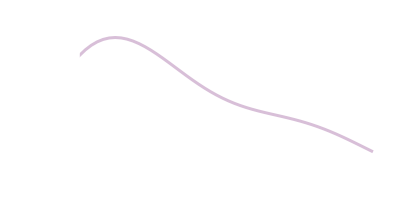

In [2]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(5.5,3))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

x = np.arange(0,50,1)/30
ax.plot(x, gas[75,50:100]/152, label='ML', c= 'thistle', linewidth=3)
# ax.axvspan(0.2, 0.4666, facecolor='black',alpha=0.4)
ax.set_xlim(0)
ax.set_ylim(0.006,0.009)
ax.set_ylabel(r'Effective Strain ($\varepsilon_{e}$)', color = 'white')
ax.set_xlabel(r'r (mm)', color = 'white')

ax.spines['left'].set_color('white')
ax.spines['bottom'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
plt.savefig('../data_new/strain.png',dpi=300,bbox_inches='tight', transparent=True)
